In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
import numpy as np
import sys
import astropy.units as u
from astropy.io import ascii, fits
from astropy.modeling.blackbody import blackbody_lambda

sys.path.insert(0, '../')
from libra import Spot, Star

In [2]:
phoenix = fits.getdata('../libra/data/phoenix/lte026.0-4.5-0.0a+0.0.BT-Settl.spec.fits')

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')
kplr_wavelength, kplr_trans = kplr['col1'], kplr['col2']
phoenix_wavelength = phoenix['Wavelength']*1000 * u.nm
phoenix_flux = phoenix['Flux'] / phoenix['Flux'].max()

kplr = ascii.read('../libra/data/filters/kepler_response_hires1.txt')

bb_2559 = blackbody_lambda(phoenix_wavelength, 2559)
bb_2600 = blackbody_lambda(phoenix_wavelength, 2600)

spitz_1 = ascii.read('../libra/data/filters/Spitzer_IRAC.I1.txt')
spitz1_wave = (spitz_1['col1'] * u.Angstrom).to(u.nm)
spitz1_trans = spitz_1['col2']

spitz_2 = ascii.read('../libra/data/filters/Spitzer_IRAC.I2.txt')
spitz2_wave = (spitz_2['col1'] * u.Angstrom).to(u.nm)
spitz2_trans = spitz_2['col2']

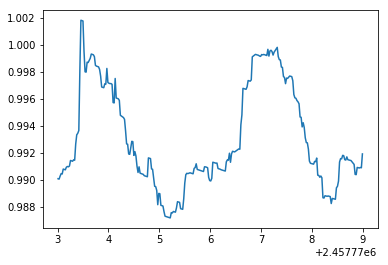

In [3]:
k2_time, k2_flux, k2_err = np.loadtxt('../libra/data/trappist1/trappist_rotation.txt', unpack=True)
k2_flux /= np.percentile(k2_flux, 98)
# slice in time
condition = (k2_time > 2457773) & (k2_time < 2457779)
k2_time, k2_flux, k2_err= k2_time[condition], k2_flux[condition], k2_err[condition]

plt.plot(k2_time, k2_flux)

std:  0.00118321694268
270 270


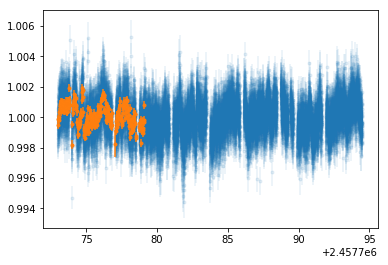

In [4]:
spitzer_time, spitzer_flux, spitzer_err, _ = np.loadtxt('../libra/data/T1_Spitzer.txt', 
                                              unpack=True, delimiter=',')
spitzer_time += k2_time.min() - spitzer_time[0]
spitzer_flux += 1

spitzer_std = np.std(spitzer_flux)
print('std: ', spitzer_std)

from scipy.stats import binned_statistic

#bins = np.arange(spitzer_time.min(), spitzer_time.max(), 1/24)
bins = np.arange(k2_time.min(), k2_time.max()+6*(k2_time[1]-k2_time[0]), k2_time[1]-k2_time[0])
bs1 = binned_statistic(spitzer_time, spitzer_flux, statistic='mean', bins=bins)
bs2 = binned_statistic(spitzer_time, spitzer_flux, statistic='std', bins=bins)
bs3 = binned_statistic(spitzer_time, spitzer_err, statistic='mean', bins=bins)
bs4 = binned_statistic(spitzer_time, spitzer_err, statistic='count', bins=bins)

plt.errorbar(spitzer_time, spitzer_flux, spitzer_err, fmt='.', alpha=0.1)

bincenters = 0.5 * (bins[1:] + bins[:-1])

spitzer_times = bincenters
spitzer_fluxes = bs1.statistic
spitzer_errors = bs3.statistic / np.sqrt(bs4.statistic)

spitzer_times = spitzer_times[~np.isnan(spitzer_fluxes)]
spitzer_errors = spitzer_errors[~np.isnan(spitzer_fluxes)]
spitzer_fluxes = spitzer_fluxes[~np.isnan(spitzer_fluxes)]

plt.errorbar(spitzer_times, spitzer_fluxes, spitzer_errors, fmt='.', zorder=100)
print(len(spitzer_times), len(k2_time))

In [5]:
sample_contrast = 1.0

def kepler_to_spitzer_contrast(kepler_contrast):
    sample_temperatures = 2559*u.K + np.arange(-200, 200, 0.5)[:, np.newaxis]*u.K

    # Start with low-res in Kepler bandpass
    bb_trial = blackbody_lambda(kplr_wavelength, sample_temperatures).value
    bb_2559 = blackbody_lambda(kplr_wavelength, 2559*u.K).value
    bb_2600 = blackbody_lambda(kplr_wavelength, 2600).value

    spectrum_interp = np.interp(kplr_wavelength, phoenix_wavelength, phoenix_flux, left=0, right=0)
    spot_trial_spectrum = spectrum_interp * bb_trial / bb_2559

    contrast = (np.trapz(spot_trial_spectrum * kplr_trans * kplr_wavelength, x=kplr_wavelength) / 
                np.trapz(spectrum_interp * kplr_trans * kplr_wavelength, x=kplr_wavelength))

    spot_temperature = sample_temperatures[np.argmin(np.abs(contrast - kepler_contrast))][0]

    # Switch to hi-res for spitzer
    bb_spot = blackbody_lambda(phoenix_wavelength, spot_temperature).value
    bb_2559 = blackbody_lambda(phoenix_wavelength, 2559).value
    bb_2600 = blackbody_lambda(phoenix_wavelength, 2600).value

    trappist_flux = phoenix_flux * bb_2559/bb_2600
    trappist_spot = trappist_flux * bb_spot/bb_2559

    trans_interp = np.interp(phoenix_wavelength, spitz2_wave/10, spitz2_trans, left=0, right=0)

    spitzer_contrast = (np.trapz(trappist_spot * trans_interp * phoenix_wavelength, x=phoenix_wavelength) / 
                        np.trapz(trappist_flux * trans_interp * phoenix_wavelength, x=phoenix_wavelength))

    return spitzer_contrast

#kepler_contrast_range = np.linspace(0, 2, 100)
#spitzer_contrast_range = np.array([kepler_to_spitzer_contrast(c) for c in kepler_contrast_range])

In [24]:
kepler_to_spitzer_contrast(1.05)

<Quantity 1.0071227031764731>

In [6]:
#plt.plot(kepler_contrast_range, spitzer_contrast_range)
#contrast_p = np.polyfit(kepler_contrast_range, spitzer_contrast_range, 10)

contrast_p = np.array([ -2.86673787e+00,   3.04324483e+01,  -1.39102663e+02,
                         3.58168264e+02,  -5.70729646e+02,   5.82371946e+02,
                        -3.80959509e+02,   1.55908866e+02,  -3.81530016e+01,
                         5.54607524e+00,   3.85779028e-01])

def kepler_to_spitzer_contrast_interp(kepler_contrast):
    return np.polyval(contrast_p, kepler_contrast)

#plt.plot(kepler_contrast_range, np.polyval(contrast_p, kepler_contrast_range), ls='--')

In [17]:
def model(p, kepler_time):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, kepler_contrast = p
    
    # Kepler
    spots = [Spot.from_latlon(lat0, lon0, rad0, contrast=kepler_contrast), 
             Spot.from_latlon(lat1, lon1, rad1, contrast=kepler_contrast), 
             Spot.from_latlon(lat2, lon2, rad2, contrast=kepler_contrast)]

    kepler_star = Star(spots=spots, rotation_period=3.3*u.day)
    kepler_model_flux = kepler_star.flux(kepler_time)
    kepler_model_flux /= np.max(kepler_model_flux)
    
    # Spitzer
    spitzer_contrast = kepler_to_spitzer_contrast_interp(kepler_contrast)
    spitzer_model_flux = kepler_model_flux * spitzer_contrast / kepler_contrast
    spitzer_model_flux /= np.median(spitzer_model_flux)
    
    return kepler_model_flux, spitzer_model_flux

def chi2(p, kepler_time):
    kepler_model_flux, model_spitzer_flux = model(p, kepler_time)
    k2_chi2 = np.sum((kepler_model_flux - k2_flux)**2 / (2*k2_err)**2)
    spitzer_chi2 = np.sum((model_spitzer_flux - spitzer_fluxes)**2 / (2*spitzer_errors)**2)
    return k2_chi2 + spitzer_chi2

def lnprior(p):
    lat0, lon0, rad0, lat1, lon1, rad1, lat2, lon2, rad2, contrast = p
    lats = np.array([lat0, lat1, lat2])
    lons = np.array([lon0, lon1, lon2])
    rads = np.array([rad0, rad1, rad2])
    
    if np.any(lats < -90) or np.any(lats > 90):
        return -np.inf
    if np.any(lons < 0) or np.any(lons > 360):
        return -np.inf
    if np.any(rads < 0) or np.any(rads > 1):
        return -np.inf
#    if not (300 < lon0 < 360 and 30 < lon1 < 70 and 190 < lon2 < 280):
#     if not (110 < lon0 < 170 and 200 < lon1 < 300 and 0 < lon2 < 80): # dark
#        return -np.inf
    if not (1 < contrast < 2):
        return -np.inf
    return 0

def lnprob(p, kepler_time):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + -0.5*chi2(p, kepler_time)

initp = np.array([0, 330, 0.18, 
                  0,  50, 0.1, 
                  0, 210, 0.1, 1.1])
ndim, nwalkers = 10, 40
pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

In [18]:
# initp = np.array([  0.00000000e+00,   145,  0.1,
#                     0.00000000e+00,   225,  0.1,
#                     0.00000000e+00,   70,   0.1, 
#                     0.89])
# pos = [initp + 1e-3*np.random.randn(ndim) for i in range(nwalkers)]

# fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# ax[0].plot(k2_time, k2_flux)
# ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*3, fmt='.')
# for p in pos:
#     model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
#     ax[0].plot(k2_time, model_k2_fluxes)
#     ax[1].plot(k2_time, model_spitzer_flux)
#     #print(model_spitzer_std, spitzer_std)

In [19]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(k2_time, ), 
                                threads=4)
sampler.run_mcmc(pos, 500);

In [20]:
sampler.run_mcmc(pos, 1500);

In [21]:
n_burnin = 400
samples = samples = sampler.chain[:, n_burnin:, :].reshape((-1, ndim))
# samples = sampler.flatchain

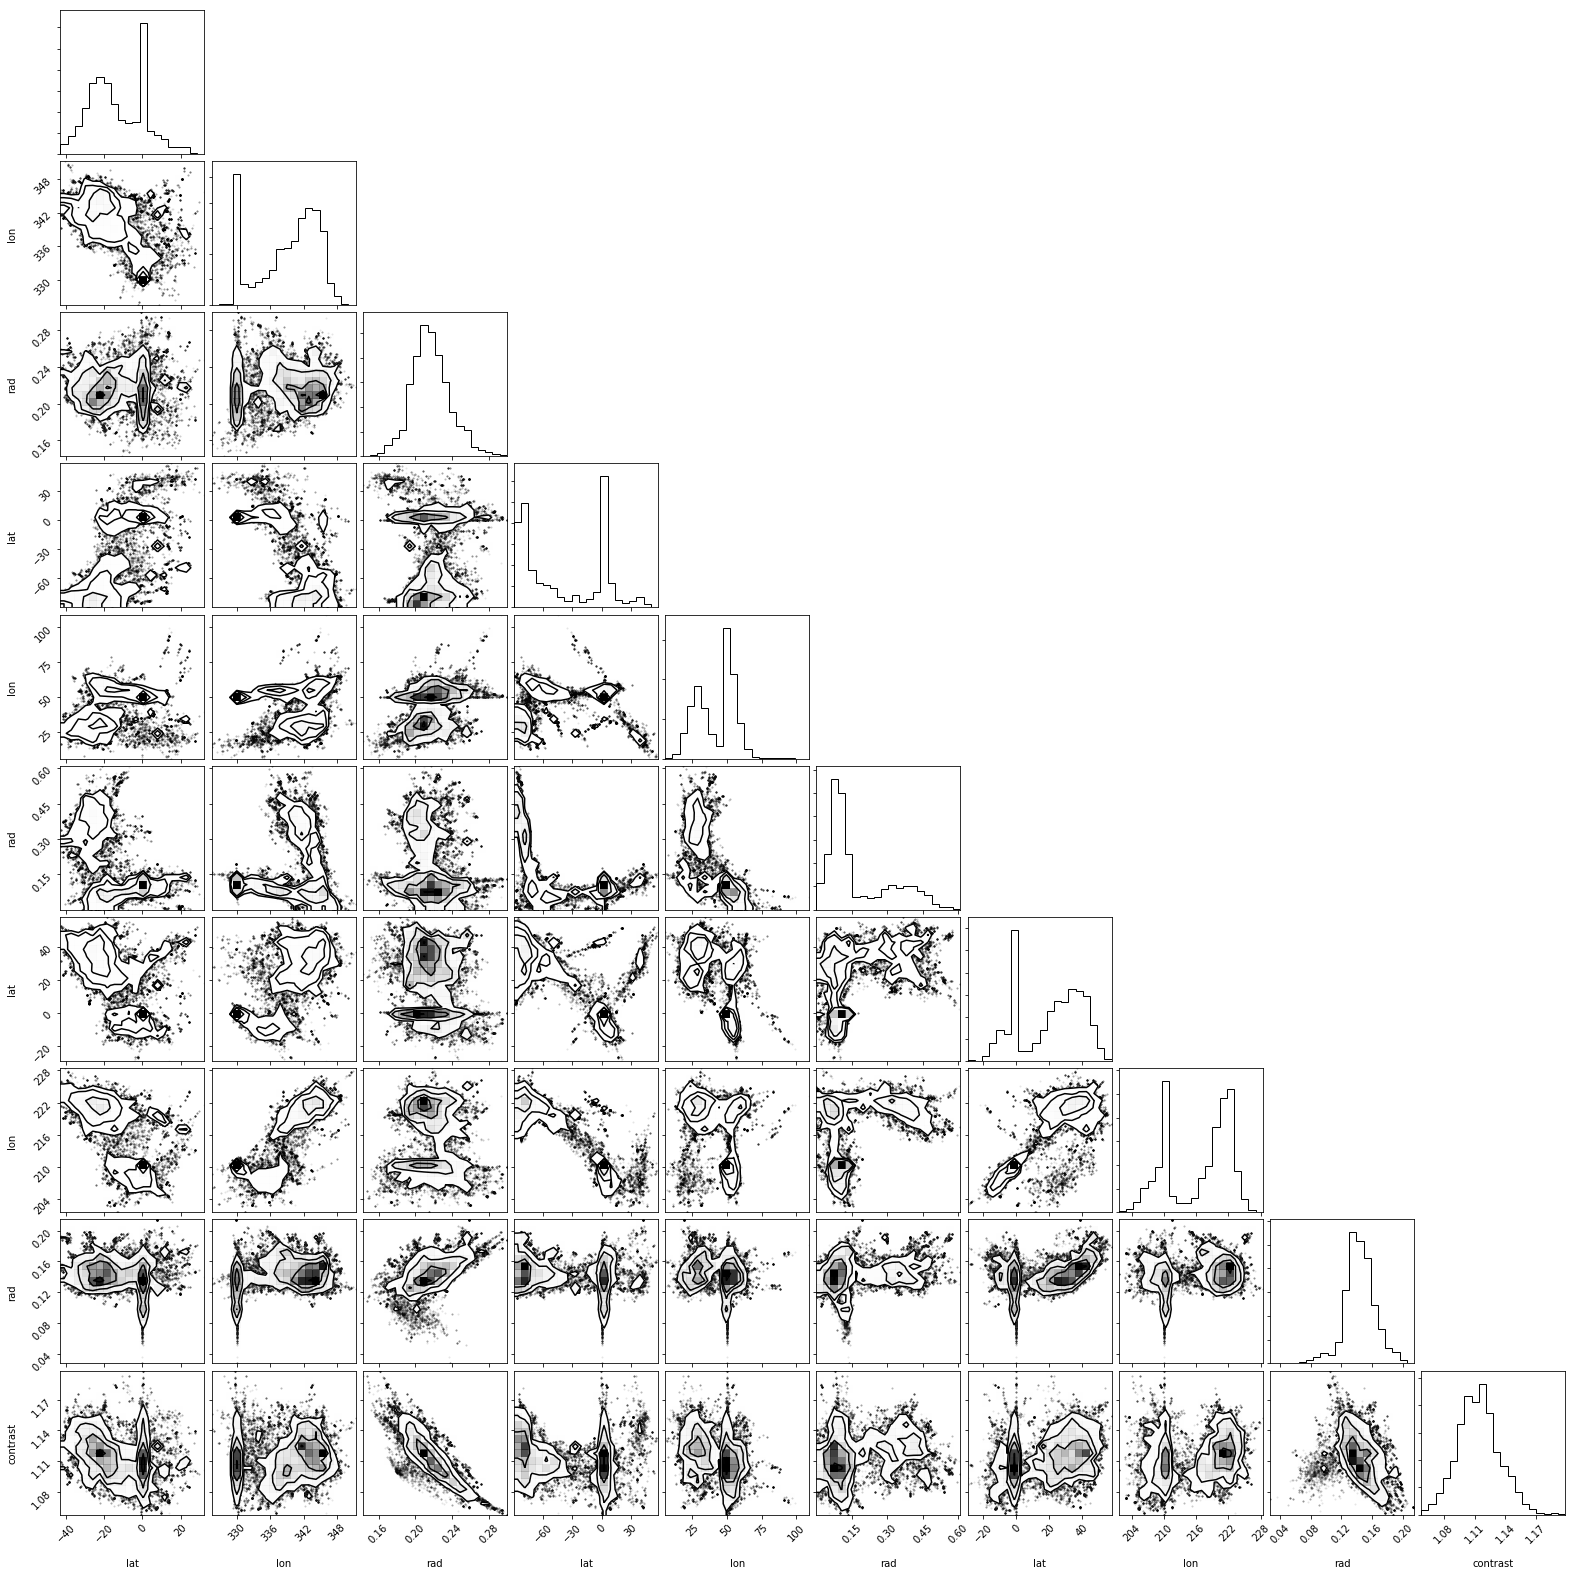

In [22]:
labels = ['lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'lat', 'lon', 'rad', 'contrast']
from corner import corner

corner(samples, labels=labels)

#plt.savefig('corner_bright_spitzer.png', bbox_inches='tight', dpi=250)
plt.show()

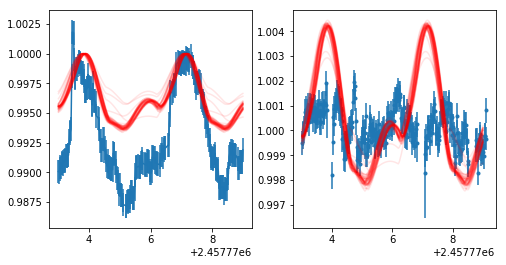

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].errorbar(k2_time, k2_flux, 2*k2_err)
ax[1].errorbar(spitzer_times, spitzer_fluxes, spitzer_errors*2, fmt='.')
for p in samples[np.random.randint(0, samples.shape[0], 50), :]:
    model_k2_fluxes, model_spitzer_flux = model(p, k2_time)
    ax[0].plot(k2_time, model_k2_fluxes, alpha=0.1, color='r', zorder=10)
    ax[1].plot(k2_time, model_spitzer_flux, alpha=0.1, color='r', zorder=10)
    #print(model_spitzer_std, spitzer_std)